# Automatsko vodjenje objekata u prostoru

Autor: Djordje Marjanovic

## Zadatak 1

Analizirati primenu metoda paralelnog vođenja u dve tačke u vertikalnoj 
ravni za sledeći scenario:

**Cilj** je letelica i nalazi se u početku na poziciji
$x = 5000\mathrm{m}$, $y = 2500\mathrm{m}$.
Kreće se brzinom $200\frac{\mathrm{m}}{\mathrm{s}}$.
Pocetni ugao elevacije je $0$.
Od početnog trenutka vrši manevar od $1g$ na više.

**Vodjeni objekat** je letelica koja se u pocetnom trenutku nalazi u 
koordinatnom početku. Brzina objekta je sve vreme 
$400\frac{\mathrm{m}}{\mathrm{s}}$. Početno usmerenje vektora brzine objekta
 je $20^\circ$.

Simulirati trajektoriju vodjenog objekta i cilja, odrediti krajnji promasaj i
 profil promene normalnog ubrzanja.

### Postavka

In [76]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ipywidgets import interact

### Cilj

In [77]:
def create_target(t):
    x0 = 5000
    y0 = 2500
    vx0 = 200
    ay0 = 1
    return (
        x0 + vx0 * t,
        y0 + ay0 * t ** 2 / 2,
        vx0 + 0 * t,
        ay0 * t
    )

### Upravljanje

In [78]:
def control(state, target_state, e0):
    x, y, vx, vy = state
    target_x, target_y, target_vx, target_vy = target_state
    
    R = np.array([target_x - x, target_y - y, 0])
    Vr = np.array([target_vx - vx, target_vy - vy, 0])
    
    acc = Vr
    acc = np.cross(R, acc)
    acc = np.cross(R, acc)
    acc = acc / np.linalg.norm(R) ** 3
    acc = acc * np.linalg.norm(Vr)
    
    acc_normal = np.array([vy, -vx, 0])
    acc_normal = acc_normal / np.linalg.norm(acc_normal)
    acc_normal = acc.dot(acc_normal)
    return acc_normal * 20

### Model letelice

In [79]:
target_x, target_y, target_vx, target_vy = create_target(0)
e0 = np.arctan2(target_y, target_x)

def model(t, state):
    acc_normal = control(state, create_target(t), e0)
    
    x, y, vx, vy = state
    acc_angle = np.arctan2(vy, vx) + np.pi / 2
    acc = {
        'x': acc_normal * np.cos(acc_angle),
        'y': acc_normal * np.sin(acc_angle)
    }
    
    return np.array([vx, vy, acc['x'], acc['y']])

### Simulacija

In [80]:
def end_event(t, state):
    x, y, vx, vy = state
    target_x, target_y, target_vx, target_vy = create_target(t)
    dist = np.sqrt((target_x - x) ** 2 + (target_y - y) ** 2)
    return dist - 50

end_event.terminal = True

t_max = 100
dt = 0.01
x0, y0 = 0, 0
v0 = 400
angle0 = 20 / 180 * np.pi
vx0, vy0 = v0 * np.cos(angle0), v0 * np.sin(angle0)
t = np.linspace(0, t_max, int(t_max / dt + 1))

solution = solve_ivp(
    model,
    (0, t_max),
    [0, 0, vx0, vy0],
    t_eval = t,
    events = end_event
)
t = solution.t

### Vizuelizacija

In [81]:
def plane_outline(x, y, vx, vy, scale = 100, c='k'):
    plane_top = np.array([
        [-2.2, -2.7, -2, -0.5, -1.2, 0.5, 1.2, 1.9, 2],
        [0, 1, 0.4, 0.4, 2.5, 0.4, 0.4, 0.2, 0]
    ]) * np.array([[1], [0.7]])
    plane_bottom = np.flip(plane_top * np.array([[1], [-1]]), axis = 1)
    plane = np.concatenate([plane_top, plane_bottom], axis = 1)
    angle = np.arctan2(vy, vx)
    plane = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ]).dot(plane) * scale
    plt.plot(plane[0, :] + x, plane[1, :] + y, c)


x, y, vx, vy = solution.y
target_x, target_y, target_vx, target_vy = create_target(t) 
dist = np.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)
closest_index = np.argmin(dist)

e = np.arctan2(target_y - y, target_x - x)

num_parallels = 20

@interact(time=(0.0, t_max))
def plot(time=0.0):
    index = np.argmin(np.abs(t - time))

    fig, ax = plt.subplots(figsize = (15, 15))

    for i in range(num_parallels):
        parallel_index = int(i * (len(t) - 1) / (num_parallels - 1))
        p = plt.plot(
            [x[parallel_index], target_x[parallel_index]],
            [y[parallel_index], target_y[parallel_index]],
            '--k',
            alpha = 0.5
        )

    plt.plot(x, y, alpha = 0.5, c='C0')
    plane_outline(x[index], y[index], vx[index], vy[index], c='C0')
    plt.plot([x[closest_index]], [y[closest_index]], '^', c='C0')

    plt.plot(target_x, target_y, alpha = 0.5, c='C1')
    plane_outline(
        target_x[index], 
        target_y[index], 
        target_vx[index], 
        target_vy[index],
        c='C1'
    )
    plt.plot([target_x[closest_index]], [target_y[closest_index]], 'v', c='C1')
    ax.set_aspect('equal')
    plt.show()


interactive(children=(FloatSlider(value=0.0, description='time'), Output()), _dom_classes=('widget-interact',)…

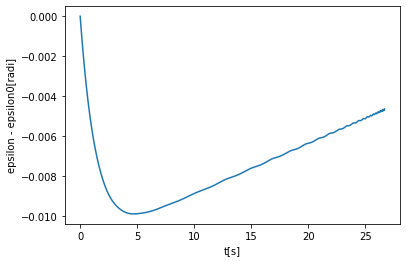

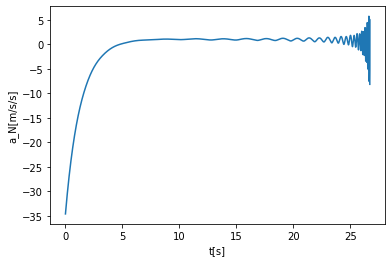

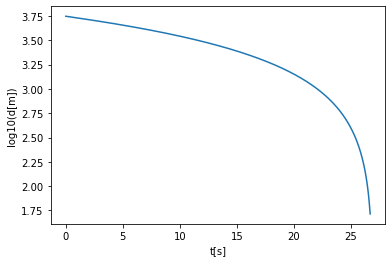

51.77191735319138


In [40]:
plt.plot(t, e - e0)
plt.xlabel('t[s]')
plt.ylabel('epsilon - epsilon0[radi]')
plt.show()

control_t = np.zeros((t.shape))
for i, time in enumerate(t):
    control_t[i] = control(solution.y[:, i], create_target(time), e0)

# plt.plot(t, control(solution.y, target.T, e0))
plt.plot(t, control_t)
plt.xlabel('t[s]')
plt.ylabel('a_N[m/s/s]')
plt.show()

plt.plot(t, np.log10(dist))
plt.xlabel('t[s]')
plt.ylabel('log10(d[m])')
plt.show()

print(dist[-1])


## Zadatak 2

U sklopu sistema vođenja definisanog u domaćem zadatku 1. simulirati efekte 
realnog trekera, dinamičkog modela objekta vođenja i autopilota.

Sve slučajeve samonavođenja posmatrati kao proporcionalnu navigaciju sa 
odgovarajućim vrednostima navigacione konstante. Za paralelno zbližavanje 
usvojiti $C = 20$.

U slučajevima u kojima je zadatak bio da se simulira adjungovani sistem, 
posmatrati ponašanje originalnog sistema.

1. **Dinamički model objekta vođenja**

Definisan je dinamičkim parametrima:

* $K = 0.75$
* $T_1 = 1\mathrm{s}$
* $\omega_n = 20\frac{\mathrm{rad}}{\mathrm{s}}$
* $\zeta = 0.1$


2. **Autopilot**

Definisati strukturu autopilota namenjenog za upravljanje normalnim ubrzanjem.

Naponski signali su limitirani na $\pm 10 V$

Zanemariti dinamiku pokretača krmila.

Hod krmila je limitiran na $\pm20^\circ$


3. **Treker u sistemima koji realizuju komandno vođenje primeniti samo na 
praćenje cilja.**

*ova tacka se preskace*

Servo sistem trekera je na bazi elektromotornog pogona.

Parametri motora i inercije platforme su:

* $T_{\mathrm{motora}} = 0.5\mathrm{s}$
* $T_{\mathrm{platforme}} = 0.5\mathrm{s}$

Kontroler je PI tipa.

Primeniti kolo unutrašnje povratne sprege po signalu sa tahogeneratora.

Simulirati dejstvo termičkog šuma u senzoru za praćenje.

4. **Treker u sistemima koji realizuju samonavođenje**

Realizovan na bazi teškog precesionog žiroskopa sa tork motorom čija se 
inercija može zanemariti.

Usvojiti da je hod glave za samonavođenje mehanički ograničen na $\pm60^\circ$, 
a da je vidno polje senzora ograničeno na $\pm30^\circ$.

Simulirati dejstvo termičkog šuma u senzoru za praćenje.

### Postavka

In [57]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ipywidgets import interact
import control

### Parametri

In [58]:
parameters = {
    "K": 0.75,
    "T1": 1,
    "omegan": 20,
    "zeta": 0.1,
    "Ksg": 5,
    "Kacc": 1,
    "Vo": 200
}

### Objekat vodjenja

In [59]:
def model():
    K = parameters['K']
    T1 = parameters['T1']
    omegan = parameters['omegan']
    zeta = parameters['zeta']
    T = 2 * np.pi / omegan
    
    return control.TransferFunction([K * T1, K], [T**2, 2 * T * zeta, 1])
    
print(model())


      0.75 s + 0.75
--------------------------
0.0987 s^2 + 0.06283 s + 1



### Autopilot

In [60]:
def autopilot():
    T1 = parameters['T1']
    Vo = parameters['Vo']
    Ksg = parameters['Ksg']
    Kacc = parameters['Kacc']
    
    M = model()
    A = control.TransferFunction([T1], [T1, 1]) * Vo / T1
    
    P = M / (1 + M * Ksg)
    F = P * A / (1 + P * A * Kacc)
    
    return control.minreal(F)

print(autopilot())

8 states have been removed from the model

        1520
--------------------
s^2 + 38.63 s + 1568



### Treker

In [61]:
def tracker():
    K1 = K2 = H = 10
    K = K1 * K2 / H
    T = control.TransferFunction([K], [1, 0])
    
    return T / (1 + T)

print(control.minreal(tracker()))

1 states have been removed from the model

  10
------
s + 10



### Ceo sistem objekta upravljanja

8 states have been removed from the model
1 states have been removed from the model


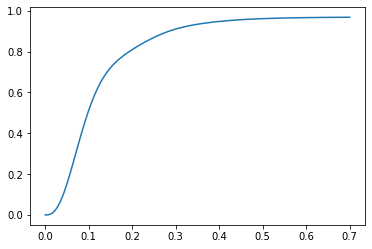

In [63]:
def object():
    T = tracker()
    A = autopilot()
    
    return control.tf2ss(control.minreal(T * A))

O = object()
t, y = control.step_response(O)
plt.plot(t, y)
plt.show()

### Cilj

In [64]:
def create_target(t):
    x0 = 5000
    y0 = 2500
    vx0 = 200
    ay0 = 1
    return (
        x0 + vx0 * t,
        y0 + ay0 * t ** 2 / 2,
        vx0 + 0 * t,
        ay0 * t
    )

### Upravljanje

In [65]:
def control(state, target_state, e0):
    x, y, vx, vy, p0, p1, p2 = state
    target_x, target_y, target_vx, target_vy = target_state
    
    R = np.array([target_x - x, target_y - y, 0])
    Vr = np.array([target_vx - vx, target_vy - vy, 0])
    
    acc = Vr
    acc = np.cross(R, acc)
    acc = np.cross(R, acc)
    acc = acc / np.linalg.norm(R) ** 3
    acc = acc * np.linalg.norm(Vr)
    
    acc_normal = np.array([vy, -vx, 0])
    acc_normal = acc_normal / np.linalg.norm(acc_normal)
    acc_normal = acc.dot(acc_normal)
    return acc_normal * 20


### Model letelice

In [66]:
target_x, target_y, target_vx, target_vy = create_target(0)
e0 = np.arctan2(target_y, target_x)

def controlled_plane(t, state):
    x, y, vx, vy, p0, p1, p2 = state
    p = np.array([[p0], [p1], [p2]])
    
    acc_normal = control(state, create_target(t), e0)
    p_prime = O.A.dot(p) + O.B.dot(acc_normal)
    acc_hat = O.C.dot(p) + O.D.dot(acc_normal)
    
    acc_angle = np.arctan2(vy, vx) + np.pi / 2
    acc = {
        'x': acc_hat * np.cos(acc_angle),
        'y': acc_hat * np.sin(acc_angle)
    }
    
    return np.array([
        vx, vy, acc['x'], acc['y'], p_prime[0], p_prime[1], p_prime[2]
    ])

### Simulacija

In [76]:
def end_event(t, state):
    x, y, vx, vy, p0, p1, p2 = state
    target_x, target_y, target_vx, target_vy = create_target(t)
    dist = np.sqrt((target_x - x) ** 2 + (target_y - y) ** 2)
    return dist - 50

end_event.terminal = True

t_max = 100
dt = 0.01
x0, y0 = 0, 0
v0 = 400
angle0 = 20 / 180 * np.pi
vx0, vy0 = v0 * np.cos(angle0), v0 * np.sin(angle0)
t = np.linspace(0, t_max, int(t_max / dt + 1))

solution = solve_ivp(
    controlled_plane,
    (0, t_max),
    [0, 0, vx0, vy0, 0, 0, 0],
    t_eval = t,
    events = end_event
)
t = solution.t
t_max = solution.t[-1]

### Vizuelizacija

In [77]:
def plane_outline(x, y, vx, vy, scale = 100, c='k'):
    plane_top = np.array([
        [-2.2, -2.7, -2, -0.5, -1.2, 0.5, 1.2, 1.9, 2],
        [0, 1, 0.4, 0.4, 2.5, 0.4, 0.4, 0.2, 0]
    ]) * np.array([[1], [0.7]])
    plane_bottom = np.flip(plane_top * np.array([[1], [-1]]), axis = 1)
    plane = np.concatenate([plane_top, plane_bottom], axis = 1)
    angle = np.arctan2(vy, vx)
    plane = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ]).dot(plane) * scale
    plt.plot(plane[0, :] + x, plane[1, :] + y, c)


x, y, vx, vy, p0, p1, p2 = solution.y
target_x, target_y, target_vx, target_vy = create_target(t) 
dist = np.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)
closest_index = np.argmin(dist)

e = np.arctan2(target_y - y, target_x - x)

num_parallels = 20

@interact(time=(0.0, t_max))
def plot(time=0.0):
    index = np.argmin(np.abs(t - time))

    fig, ax = plt.subplots(figsize = (15, 15))

    for i in range(num_parallels):
        parallel_index = int(i * (len(t) - 1) / (num_parallels - 1))
        p = plt.plot(
            [x[parallel_index], target_x[parallel_index]],
            [y[parallel_index], target_y[parallel_index]],
            '--k',
            alpha = 0.5
        )

    plt.plot(x, y, alpha = 0.5, c='C0')
    plane_outline(x[index], y[index], vx[index], vy[index], c='C0')
    plt.plot([x[closest_index]], [y[closest_index]], '^', c='C0')

    plt.plot(target_x, target_y, alpha = 0.5, c='C1')
    plane_outline(
        target_x[index], 
        target_y[index], 
        target_vx[index], 
        target_vy[index],
        c='C1'
    )
    plt.plot([target_x[closest_index]], [target_y[closest_index]], 'v', c='C1')
    ax.set_aspect('equal')
    plt.show()


interactive(children=(FloatSlider(value=0.0, description='time', max=26.7), Output()), _dom_classes=('widget-i…

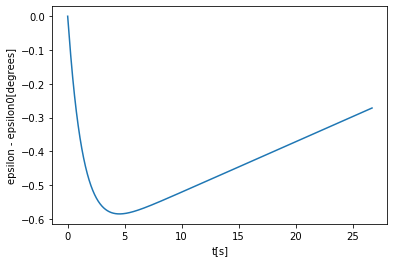

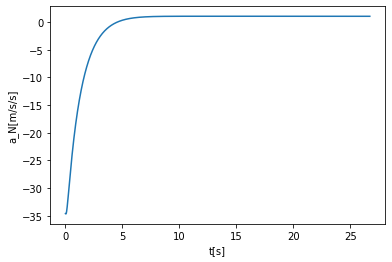

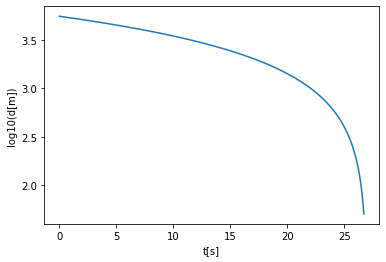

50.21178462918958


In [78]:
plt.plot(t, (e - e0) / np.pi * 180)
plt.xlabel('t[s]')
plt.ylabel('epsilon - epsilon0[degrees]')
plt.show()

control_t = np.zeros((t.shape))
for i, time in enumerate(t):
    control_t[i] = control(solution.y[:, i], create_target(time), e0)

# plt.plot(t, control(solution.y, target.T, e0))
plt.plot(t, control_t)
plt.xlabel('t[s]')
plt.ylabel('a_N[m/s/s]')
plt.show()

plt.plot(t, np.log10(dist))
plt.xlabel('t[s]')
plt.ylabel('log10(d[m])')
plt.show()

print(dist[-1])